In [20]:
import datetime, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix
from scipy.linalg import svd
from cvxpy import Variable, Problem, Minimize, Maximize

warnings.filterwarnings('ignore')

In this notebook I explore applying the <b>minimax principle for minimizing the worst possible loss in two player zero-sum games</b>. Below I introduce a two player zero-sum game, where the row choices are for player one and column choices for player two. Note, minimax (to minimize the maximum loss) and maximin (to maximize the minimum gain) are interchangeably used, with maximin being more common in game-theory.

Player one receives the payoff in the table cells and player two loses the same (negative) amount. The goal is reciprocal, player one aims to maximize its payoff and player two to minimize its loss.

In [16]:
g = pd.DataFrame(np.array([[0.38, 0.08], [0.11, 0.69]]))
g

,0,1
0,0.38,0.08
1,0.11,0.69


The players obviously don't know their strategies in advance and they pick an action simultaneously.

In the above example the maximum payoff for player one is 0.69 if players choose actions (1, 1), however for player one there's the risk of player two choosing (·,0) and receive 0.11 instead. Player two is also not clearly decisive, they can minimize their loss at -0.08 for (0,1) cofiguration but that has a high risk of landing in (1,1) and getting -0.69. It is clear that the safest option for player one is (0,·) regardless of what player two picks. Notably, with that strategy player one will definitely miss on the 0.69 payoff but also will surely not get the lowest 0.08 payoff.

In game-theory the <b>maximin</b> value is the highest value that the player can be sure to get without knowing the actions of the other players; equivalently, it is the lowest value the other players can force the player to receive when they know the player's action. Referring with $i$ for the row player and $j$ for the column player and a payoff function for player one $v_i$, the maximin strategy for player one is:
$$\underline{v_i}=\max_{i}\min_{j}v_i(i,j)$$
$v_i$ in this instance is a guaranteed payoff for player one if they pick (0,·), we call it the maximin payoff. For the example 2x2 game above, we the maximin payoff for player one is 0.11.

In [19]:
g.min(axis=1).max()

0.11

The strategy above is called a <b>pure strategy</b> because player one picks only one action with probability 1. The maximin principle in fact applies when player one assigns a probability distribution over the actions, so that it picks different actions with different probabilities, maximizing their payoff in expectation, such strategies are called <b>mixed strategies</b>.

In two-player zero-sum games, the mixed maximin solution is the same as the Nash equilibrium.

Knowing that player two will aim to minimize player one's payoff, the strategy that player one takes is also called <b>best response strategy</b> having that knowledge.

Below we introduce a simple solver step to find the probability distribution for each player's maximin strategy and calculate what that payoff/loss is.

In [38]:
def solve(M, player_axis, sense=True):
    beta = Variable(M.shape[player_axis])
    o = Variable(1)
    M = M.T if player_axis else M
    if sense:
        objective = Maximize(o)
        constraints = [beta>=0, sum(beta)==1, beta @ matrix(M) >= o]
    else:
        objective = Minimize(o)
        constraints = [beta>=0, sum(beta)==1, beta @ matrix(M) <= o]
    Problem(objective, constraints).solve()
    return np.array(beta.value)

In [44]:
d_p1 = solve(g.values, 0, True)
d_p2 = solve(g.values, 1, False)

In [50]:
print("Player one would pick action one with {} and action two with {}".format(*d_p1))
print("Player two would pick action one with {} and action two with {}".format(*d_p2))

Player one would pick action one with 0.6590909086975348 and action two with 0.34090909130246805
Player two would pick action one with 0.6931818185166546 and action two with 0.3068181814833449


For the probability distributions calculated, we observe that we have found the <b>Nash equilibrium</b> for this game, and the absolute payoff/loss is identical for both players:

In [51]:
np.dot(d_p1, g.values), np.dot(d_p2, g.values.T)

(array([0.28795455, 0.28795455]), array([0.28795455, 0.28795455]))

We can also write the payoff function to player one, as a linear combination of the probabilities of each player's action and those actions' values, where $p_1$ refers to player choosing action 1 and $p_2$ refers to player two choosing action 1:
$$v_i = p_1p_2v_i(1,1) + (1-p_1)p_2v_i(2,1) + p_1(1-p_2)v_i(1,2) + (1-p_1)(1-p_2)v_i(2,2)$$

In [142]:
v_1 = []
for p1 in np.linspace(0, 1, 50):
    for p2 in np.linspace(0, 1, 50):
        v_1.append([p1, p2, np.dot(np.array([1 - p2, p2]), np.dot(np.array([1 - p1, p1]), g))])
v_1 = pd.DataFrame(v_1, columns=['p1', 'p2', 'v_1'])

Below we observe the payoff surface for the given game, as well as it's Nash equilibrium at the maximin point:

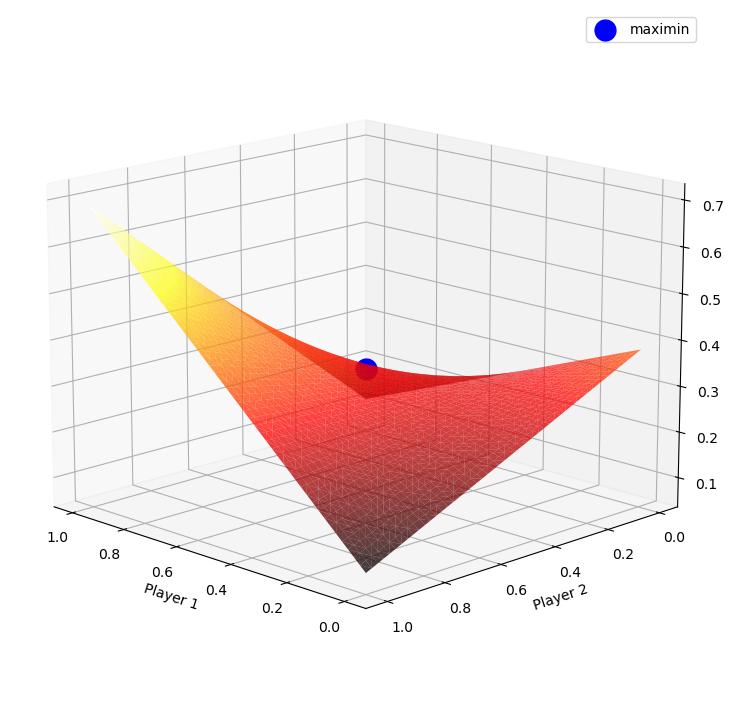

In [177]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

ax.plot_trisurf(v_1['p1'], v_1['p2'], v_1['v_1'], cmap='hot', alpha=0.75)
ax.scatter([d_p1[0]], [d_p1[1]], [np.dot(d_p1, g.values)[0]], s=225, color='blue', label='maximin')
ax.view_init(15, 135)
ax.set_xlabel('Player 1')
ax.set_ylabel('Player 2')
plt.legend()
plt.show()

To be continued: Nash equilibrium and player behaviour via differentiation of the payoff function, maximin in statistical decision theory and maximin in politics